In [1]:
%matplotlib inline
import numpy as np
import theano
import pymc3 as pm
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 
sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
import warnings
from scipy.stats import ks_2samp, kstest

Running on PyMC3 v3.9.1


## SANI

In [40]:
data_healthy = np.genfromtxt('Data after SS/2018-10-12T14-03-45MIP nr 2, baseline,  control, H9N healthy.h5.txt', delimiter=',')

In [41]:
list_neuron = []
for neuron in data_healthy:
    if neuron[neuron!=0].shape[0]>1000:
        list_neuron.append(neuron[neuron!=0])

In [70]:
data_healthy = list_neuron[12]

In [71]:
data_healthy=data_healthy[data_healthy>100*10000]
data_healthy=data_healthy[data_healthy<300*10000]

In [72]:
data_healthy.shape

(5629,)

In [73]:
data_healthy

array([1000661., 1001055., 1001093., ..., 2998078., 2998599., 2999835.])

In [74]:
ISI_healthy = np.diff(data_healthy)/10000

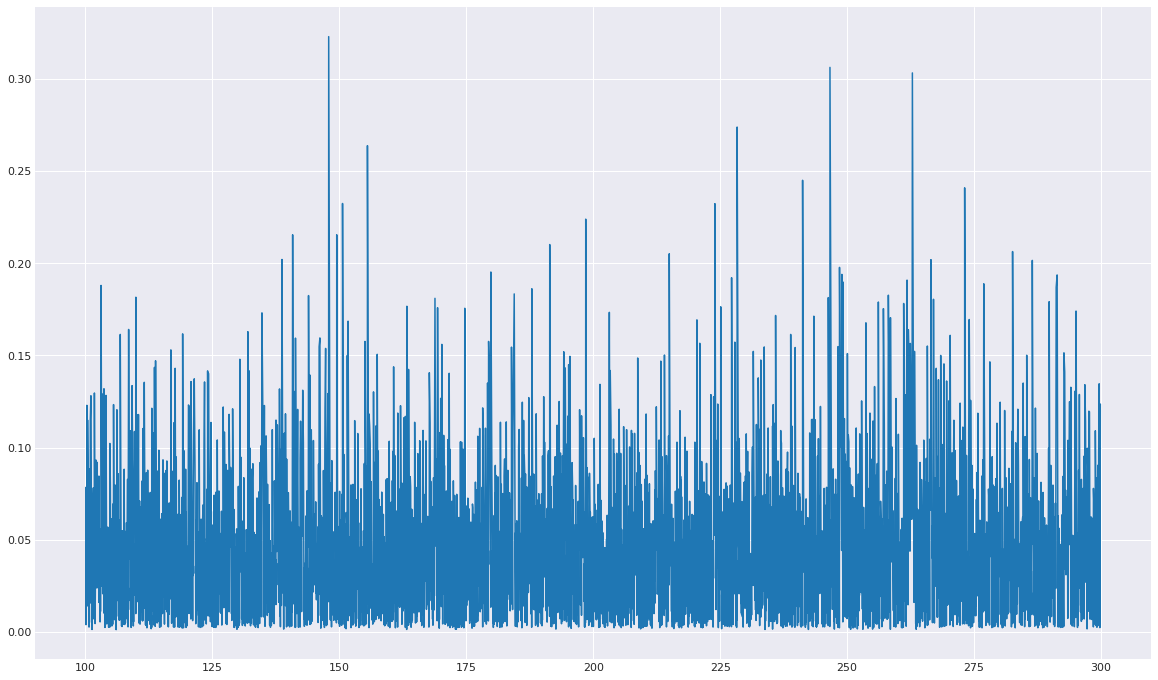

In [75]:
plt.figure(figsize=(20,12))
plt.plot(data_healthy[:-1]/10000,ISI_healthy)

In [76]:
min(ISI_healthy)

0.0011

<ipython-input-77-2993b8d7af15>:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(bins[:-1], prob)                 # ... and plot the probabilities,                # ... with fixed x-limits,


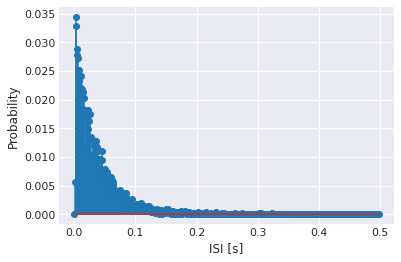

In [77]:
bins = np.arange(0, .5, 0.001)           # Define 1 ms bins for histogram,
counts, _ = np.histogram(ISI_healthy, bins)  # ... compute histogram of the ISIs,
prob = counts / len(ISI_healthy)             # ... convert to probability,
plt.figure()                 # ... create figure and axes objects that we can reuse later,
plt.stem(bins[:-1], prob)                 # ... and plot the probabilities,                # ... with fixed x-limits,
plt.xlabel('ISI [s]')                        # ... and axes labeled.
plt.ylabel('Probability')
plt.show()

## Model Inverse Gaussian

In [28]:
with pm.Model() as model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
    lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
    obs1 = pm.Wald('like',mu=mu1,lam=lam1,observed=ISI_healthy)
    
    
    step = pm.NUTS(target_accept=0.9)
    trace = pm.sample(step=step,draws=1000,tune=1000,cores=12)

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [lam1, mu1]


Sampling 12 chains for 1_000 tune and 1_000 draw iterations (12_000 + 12_000 draws total) took 5 seconds.


In [29]:
map_estimate = pm.find_MAP(model=model)

map_estimate

{'mu1_interval__': array(-0.70776302),
 'lam1_interval__': array(0.39001645),
 'mu1': array(0.0397084),
 'lam1': array(0.0278886)}

In [30]:
ig_waic = pm.waic(trace, model)

ig_waic

/home/riccardo_levi_25_gmail_com/anaconda3/envs/tesi_neuro/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 12000 by 5035 log-likelihood matrix

          Estimate       SE
elpd_waic 11476.66    80.48
p_waic        2.05        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

/home/riccardo_levi_25_gmail_com/anaconda3/envs/tesi_neuro/lib/python3.8/site-packages/pymc3/sampling.py:1617: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


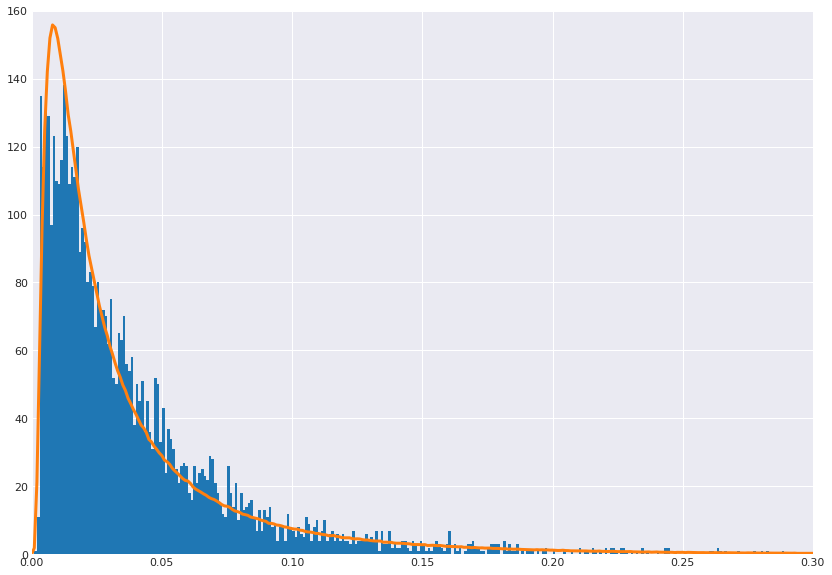

In [31]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace,1000,model=model)

bins = np.arange(0, .5, 1e-3) 
plt.figure (figsize=(14,10))

hist = np.histogram(ppc_trace['like'],bins=bins)
plt.axis([0,0.3,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

In [32]:
lista_samples=[]
for i in list(ppc_trace['like']):
    lista_samples.extend(i)

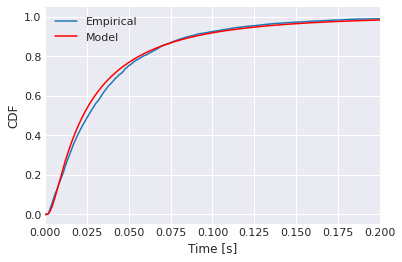

In [33]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / (len(ISI_healthy))
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / (len(lista_samples))

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

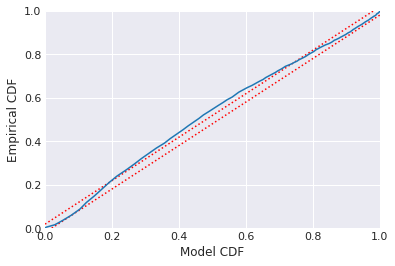

In [34]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)    
plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [35]:
from scipy.stats import ks_2samp
ks_2samp(lista_samples,ISI_healthy,mode = 'asymp')

KstestResult(statistic=0.0496985104270109, pvalue=3.090251588571917e-11)

## Model mixture = inverse gaussian + normal

In [78]:
with pm.Model() as model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
    lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
    obs1 = pm.Wald.dist(mu=mu1,lam=lam1)
    
    
    mu2 = pm.Uniform('mu2',lower=0,upper=0.2)
    sigma = pm.Uniform('sigma',lower=0.0001,upper=0.5)
    obs2 = pm.Bound(pm.Normal, lower=0.0).dist(mu=mu2,sigma=sigma)
    
    mu3 = pm.Uniform('mu3',lower=0.1,upper=0.6)
    sigma3 = pm.Uniform('sigma3',lower=0.0001,upper=0.5)
    obs3 = pm.Bound(pm.Normal, lower=0.0).dist(mu=mu3,sigma=sigma3)
    #obs2 = pm.Gamma.dist(mu=mu2,sigma=sigma)
    #obs2 = pm.SkewNormal.dist(mu=mu2,sigma=sigma)
    
    w = pm.Dirichlet('w', a=np.array([1., 1., 1.]))
    
    like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2, obs3], observed=ISI_healthy)
    
    
    step = pm.NUTS(target_accept=0.9)
    trace = pm.sample(step=step,draws=1000,tune=3000,cores=12)

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]


Sampling 12 chains for 3_000 tune and 1_000 draw iterations (36_000 + 12_000 draws total) took 93 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [51]:
map_estimate = pm.find_MAP(model=model)

map_estimate

{'mu1_interval__': array(-1.12351662),
 'lam1_interval__': array(-1.74098876),
 'mu2_interval__': array(-0.98053689),
 'sigma_interval__': array(-2.92106419),
 'mu3_interval__': array(-2.63843085),
 'sigma3_interval__': array(-1.51900818),
 'w_stickbreaking__': array([ 1.61157835, 15.32183317]),
 'mu1': array(0.03208236),
 'lam1': array(0.01447562),
 'mu2': array(0.05455705),
 'sigma': array(0.02565591),
 'mu3': array(0.13335283),
 'sigma3': array(0.08988585),
 'w': array([7.14722338e-01, 2.85277599e-01, 6.32528464e-08])}

In [52]:
pm.model_graph.model_to_graphviz(model)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

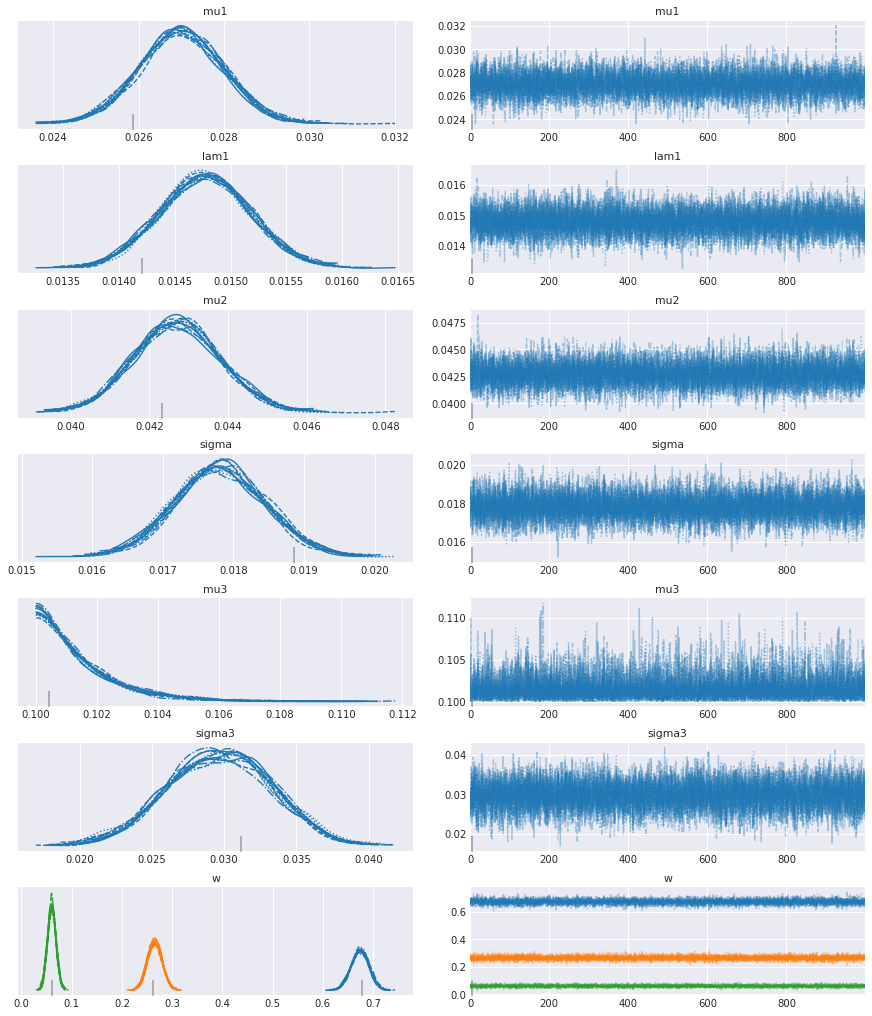

In [79]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.plots.traceplot(trace)

100%|██████████| 500/500 [01:03<00:00,  7.88it/s]


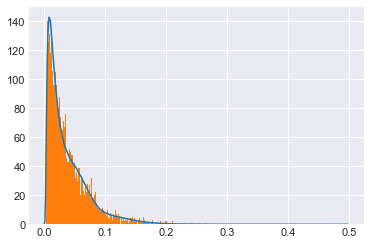

In [72]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace,500,model=model)
bins = np.arange(0, .5, 1e-3) 
hist = np.histogram(ppc_trace['like'],bins=bins)
plt.plot(hist[1][:-1],hist[0]/500);
a= plt.hist(ISI_healthy,bins)

In [73]:
lista_samples=[]
for i in list(ppc_trace['like']):
    lista_samples.extend(i)

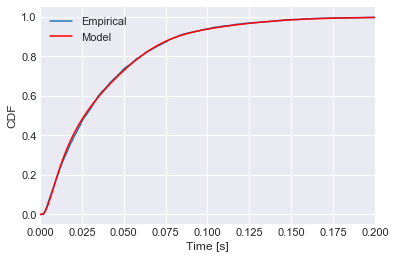

In [74]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / (len(ISI_healthy))
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / (len(lista_samples))

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

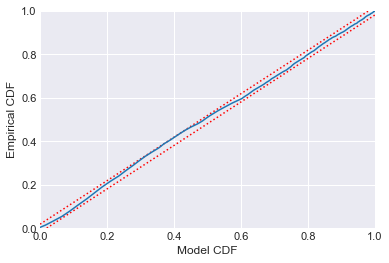

In [75]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)    
plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [77]:
from scipy.stats import ks_2samp
ks_2samp(lista_samples,ISI_healthy,mode = 'asymp')

Ks_2sampResult(statistic=0.019393197278911534, pvalue=0.04203862779477901)

## MALATI

In [117]:
data_lrrk2 = np.genfromtxt('Data_after_SS/2018-11-27T09-22-44MIP 5 BL .h5.txt', delimiter=',')

In [118]:
list_neuron = []
for neuron in data_lrrk2:
    if neuron[neuron!=0].shape[0]>1000:
        list_neuron.append(neuron[neuron!=0])
        #print(neuron[neuron!=0].shape[0])

In [119]:
data_lrrk2 = list_neuron[14]

In [120]:
data_lrrk2.shape

(4774,)

In [121]:
data_lrrk2=data_lrrk2[data_lrrk2>150*10000]
data_lrrk2=data_lrrk2[data_lrrk2<300*10000]

In [122]:
ISI_lrrk2 = np.diff(data_lrrk2)/10000

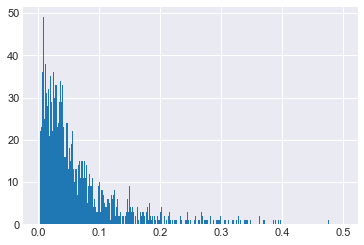

In [123]:
bins = np.arange(0, .5, 1e-3) 
a= plt.hist(ISI_lrrk2,bins)

## Model Inverse Gaussian

In [124]:
with pm.Model() as model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
    lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
    obs1 = pm.Wald('like',mu=mu1,lam=lam1,observed=ISI_lrrk2)
    
    
    step = pm.NUTS(target_accept=0.9)
    trace = pm.sample(step=step,draws=1000,tune=3000,cores=12)

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [lam1, mu1]
Sampling 12 chains, 0 divergences: 100%|██████████| 48000/48000 [00:12<00:00, 3877.31draws/s]
The acceptance probability does not match the target. It is 0.8124128377540327, but should be close to 0.9. Try to increase the number of tuning steps.


In [125]:
map_estimate = pm.find_MAP(model=model)

map_estimate

logp = 4,180, ||grad|| = 0.10145: 100%|██████████| 18/18 [00:00<00:00, 1686.19it/s]  


{'mu1_interval__': array(0.40352173),
 'lam1_interval__': array(4.99490138),
 'mu1': array(0.06395801),
 'lam1': array(0.0397982)}

/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 1702.40it/s]


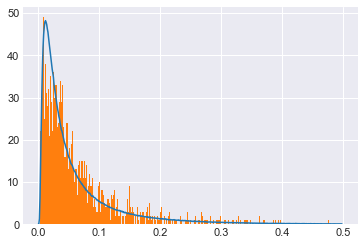

In [126]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace,1000,model=model)

bins = np.arange(0, .5, 1e-3) 
hist = np.histogram(ppc_trace['like'],bins=bins)
plt.plot(hist[1][:-1],hist[0]/1000);
a= plt.hist(ISI_lrrk2,bins)

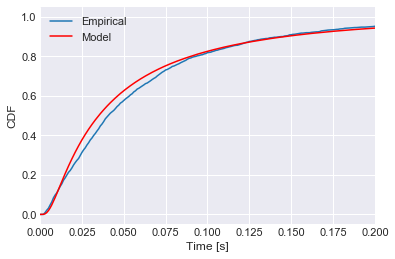

In [127]:
lista_samples=[]
for i in list(ppc_trace['like']):
    lista_samples.extend(i)
counts, _ = np.histogram(ISI_lrrk2, bins) 
prob_emp = counts / (len(ISI_lrrk2))
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / (len(lista_samples))

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()    


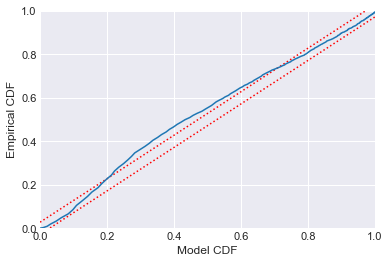

In [128]:
plt.figure()
Nlow = len(ISI_lrrk2)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)    
plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [129]:
from scipy.stats import ks_2samp
ks_2samp(lista_samples,ISI_lrrk2,mode = 'asymp')

Ks_2sampResult(statistic=0.0698319829424307, pvalue=2.389379425182759e-10)

# Mixture Model

In [130]:
with pm.Model() as model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
    lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
    obs1 = pm.Wald.dist(mu=mu1,lam=lam1)
    
    
    mu2 = pm.Uniform('mu2',lower=0,upper=0.2)
    sigma = pm.Uniform('sigma',lower=0.0001,upper=0.5)
    obs2 = pm.Bound(pm.Normal, lower=0.0).dist(mu=mu2,sigma=sigma)
    
    mu3 = pm.Uniform('mu3',lower=0.1,upper=0.6)
    sigma3 = pm.Uniform('sigma3',lower=0.0001,upper=0.5)
    obs3 = pm.Bound(pm.Normal, lower=0.0).dist(mu=mu3,sigma=sigma3)
    #obs2 = pm.Gamma.dist(mu=mu2,sigma=sigma)
    #obs2 = pm.SkewNormal.dist(mu=mu2,sigma=sigma)
    
    w = pm.Dirichlet('w', a=np.array([1., .4, .4]))
    
    like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2, obs3], observed=ISI_lrrk2)
    
    
    step = pm.NUTS(target_accept=0.9)
    trace = pm.sample(step=step,draws=1000,tune=3000,cores=12)

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 12 chains, 0 divergences: 100%|██████████| 48000/48000 [01:27<00:00, 545.62draws/s]


In [131]:
map_estimate = pm.find_MAP(model=model)

map_estimate

logp = 4,223.9, ||grad|| = 1.0632: 100%|██████████| 56/56 [00:00<00:00, 841.35it/s]  


{'mu1_interval__': array(0.20669027),
 'lam1_interval__': array(1.04208035),
 'mu2_interval__': array(-0.98687103),
 'sigma_interval__': array(-3.18951754),
 'mu3_interval__': array(-3.01803718),
 'sigma3_interval__': array(-2.33540091),
 'w_stickbreaking__': array([1.83796446, 0.68021322]),
 'mu1': array(0.05963405),
 'lam1': array(0.03217754),
 'mu2': array(0.05430611),
 'sigma': array(0.0198771),
 'mu3': array(0.12330882),
 'sigma3': array(0.04420778),
 'w': array([0.758563  , 0.16026257, 0.08117443])}

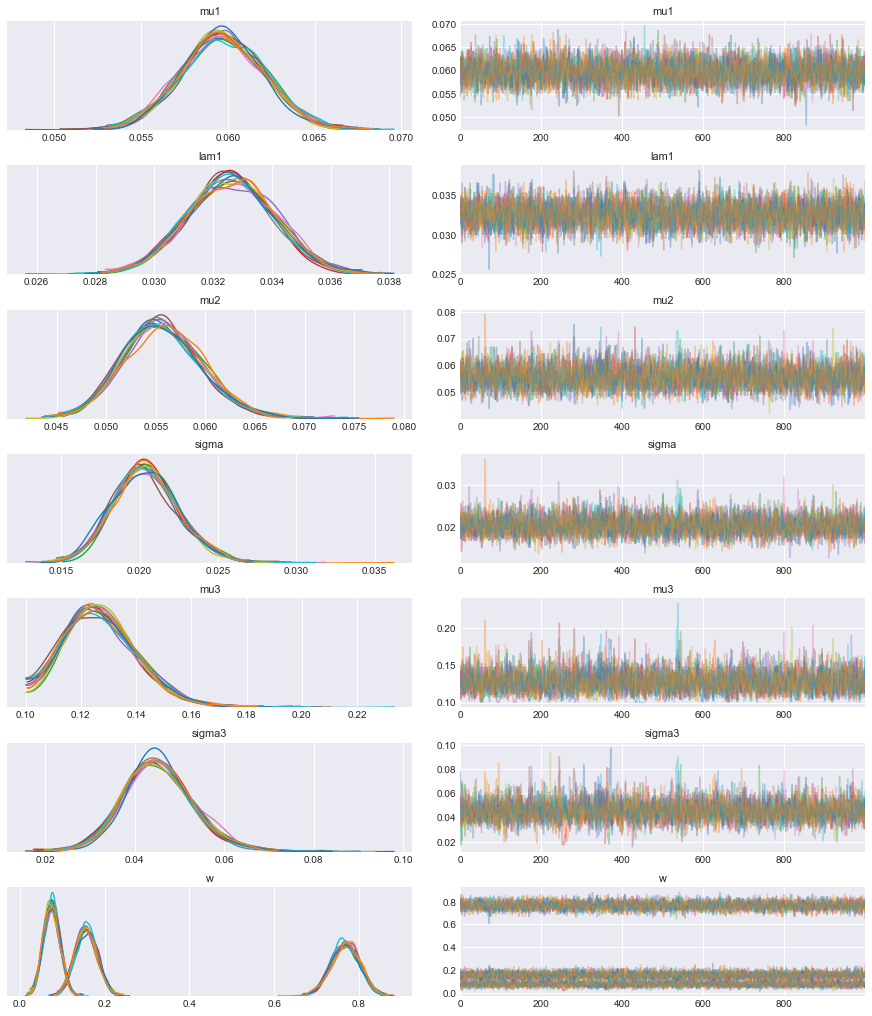

In [132]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.traceplot(trace)

In [133]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 1000,model=model)

/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:56<00:00, 17.64it/s]


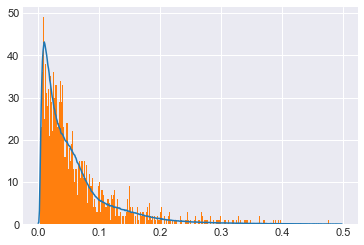

In [134]:
bins = np.arange(0, .5, 1e-3) 
hist = np.histogram(ppc_trace['like'],bins=bins)
plt.plot(hist[1][:-1],hist[0]/1000);
a= plt.hist(ISI_lrrk2,bins)

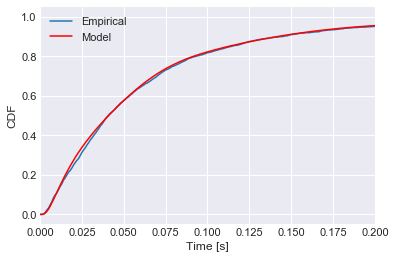

In [135]:
lista_samples=[]
for i in list(ppc_trace['like']):
    lista_samples.extend(i)
counts, _ = np.histogram(ISI_lrrk2, bins) 
prob_emp = counts / (len(ISI_lrrk2))
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / (len(lista_samples))

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show() 

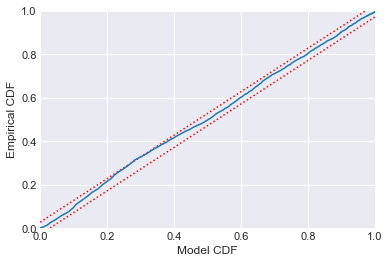

In [136]:
plt.figure()
Nlow = len(ISI_lrrk2)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)    
plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [138]:
from scipy.stats import ks_2samp
ks_2samp(lista_samples,ISI_lrrk2,mode = 'asymp').pvalue

0.0170465265908843

In [140]:
ISI_lrrk2.shape

(2345,)

## ALL NEURONS

In [141]:
def Bayesian_mixture_model(ISI_data):
    
    with pm.Model() as model:
        
        BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
        mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
        lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
        obs1 = pm.Wald.dist(mu=mu1,lam=lam1)


        mu2 = pm.Uniform('mu2',lower=0,upper=0.2)
        sigma = pm.Uniform('sigma',lower=0.0001,upper=0.5)
        obs2 = pm.Bound(pm.Normal, lower=0.0).dist(mu=mu2,sigma=sigma)

        mu3 = pm.Uniform('mu3',lower=0.1,upper=0.6)
        sigma3 = pm.Uniform('sigma3',lower=0.0001,upper=0.5)
        obs3 = pm.Bound(pm.Normal, lower=0.0).dist(mu=mu3,sigma=sigma3)
        #obs2 = pm.Gamma.dist(mu=mu2,sigma=sigma)
        #obs2 = pm.SkewNormal.dist(mu=mu2,sigma=sigma)

        w = pm.Dirichlet('w', a=np.array([1., .4, .4]))

        like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2, obs3], observed=ISI_data)


        step = pm.NUTS(target_accept=0.9)
        trace = pm.sample(step=step,draws=500,tune=1000,cores=6,progressbar=True,random_seed=10)
     

    map_estimate = pm.find_MAP(model=model)
    del map_estimate['w_stickbreaking__']
    del map_estimate['mu1_interval__']
    del map_estimate['lam1_interval__']
    del map_estimate['mu2_interval__']
    del map_estimate['sigma_interval__']
    del map_estimate['mu3_interval__']
    del map_estimate['sigma3_interval__']
    
    map_estimate['w1'] = map_estimate['w'][0]
    map_estimate['w2'] = map_estimate['w'][1]
    map_estimate['w3'] = map_estimate['w'][2]
    
    del map_estimate['w']
    
    map_estimate['n_spikes'] = ISI_data.shape[0]
    
    
    with model:
        ppc_trace = pm.sample_posterior_predictive(trace, 200,model=model)
    
    lista_samples=[]
    for i in list(ppc_trace['like']):
        lista_samples.extend(i)
    
    
    print('P_value: ',ks_2samp(lista_samples,ISI_data,mode = 'asymp').pvalue)
    
    return map_estimate

In [146]:
data_healthy = np.genfromtxt('Data_after_SS/2019-01-23T11-05-52MIP3 healthy cortical .h5.txt', delimiter=',')

In [147]:
list_healthy_neuron = []
for neuron in data_healthy:
    if neuron[neuron!=0].shape[0]>1000:
        list_healthy_neuron.append(neuron[neuron!=0])

In [148]:
dataframe = pandas.DataFrame()
counter = 0 
for neuron in list_healthy_neuron:
    neuron=neuron[neuron>100*10000]
    neuron=neuron[neuron<300*10000]
    ISI_healthy = np.diff(neuron)/10000
    map_estimate = Bayesian_mixture_model(ISI_healthy)
    df = pandas.DataFrame.from_dict(map_estimate,orient='index')
    dataframe = pandas.concat([dataframe,df],axis = 1)
    counter+=1
    print(counter)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:47<00:00, 187.57draws/s]
The acceptance probability does not match the target. It is 0.817776224375434, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 11,910, ||grad|| = 0.92882: 100%|██████████| 45/45 [00:00<00:00, 566.27it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:24<00:00,  8.04it/s]


P_value:  0.05614977716108176
1


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 271 divergences: 100%|██████████| 9000/9000 [01:01<00:00, 147.10draws/s]
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.023596156058737456, but should be close to 0.9. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = 12,398, ||grad|| = 1.3534e+05: 100%|██████████| 69/69 [00:00<00:00, 587.93it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples pa

P_value:  0.0028858271641798382
2


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [01:07<00:00, 133.57draws/s]
logp = 12,675, ||grad|| = 460.84: 100%|██████████| 100/100 [00:00<00:00, 593.32it/s]     
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:25<00:00,  7.77it/s]


P_value:  0.05673472351691245
3


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:44<00:00, 201.07draws/s]
The acceptance probability does not match the target. It is 0.8360017813220766, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 11,932, ||grad|| = 0.54297: 100%|██████████| 66/66 [00:00<00:00, 743.33it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:24<00:00,  8.10it/s]


P_value:  0.08259835305560315
4


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 172 divergences: 100%|██████████| 9000/9000 [01:07<00:00, 133.38draws/s]
The acceptance probability does not match the target. It is 0.8403422140018778, but should be close to 0.9. Try to increase the number of tuning steps.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40446478797960383, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = 14,186, ||grad|| = 0.056713: 100%|██████████| 43/43 [00:00<00:00, 631.40it/s]  
/User

P_value:  0.00998891526092326
5


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:22<00:00, 405.69draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = 4,995, ||grad|| = 0.72559: 100%|██████████| 48/48 [00:00<00:00, 816.62it/s]   
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:13<00:00, 14.85it/s]


P_value:  0.20858602600255058
6


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:40<00:00, 221.73draws/s]
logp = 6,719.1, ||grad|| = 0.47996: 100%|██████████| 75/75 [00:00<00:00, 688.26it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


P_value:  0.03433723729272842
7


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:34<00:00, 257.79draws/s]
logp = 6,355.2, ||grad|| = 0.054777: 100%|██████████| 75/75 [00:00<00:00, 660.44it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:16<00:00, 12.03it/s]


P_value:  0.15838787122738684
8


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:27<00:00, 327.61draws/s]
logp = 6,312.8, ||grad|| = 6.9462: 100%|██████████| 146/146 [00:00<00:00, 716.94it/s] 
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:16<00:00, 12.48it/s]


P_value:  0.03677730016940114
9


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:22<00:00, 393.48draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = 5,193.6, ||grad|| = 0.54155: 100%|██████████| 57/57 [00:00<00:00, 739.66it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:14<00:00, 13.64it/s]


P_value:  0.12239828520155502
10


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:39<00:00, 226.80draws/s]
logp = 6,635.8, ||grad|| = 0.69009: 100%|██████████| 56/56 [00:00<00:00, 646.29it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:16<00:00, 12.26it/s]


P_value:  0.03895822005145932
11


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:27<00:00, 326.01draws/s]
logp = 5,735.6, ||grad|| = 0.16695: 100%|██████████| 46/46 [00:00<00:00, 727.81it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:15<00:00, 12.75it/s]


P_value:  0.06524581901039328
12


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:20<00:00, 439.28draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = 4,860.1, ||grad|| = 0.0081512: 100%|██████████| 43/43 [00:00<00:00, 736.11it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:13<00:00, 14.81it/s]


P_value:  0.05841099446844576
13


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:15<00:00, 593.67draws/s]
logp = 3,550.9, ||grad|| = 0.043864: 100%|██████████| 34/34 [00:00<00:00, 742.29it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:11<00:00, 16.90it/s]


P_value:  0.14326829411429506
14


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:18<00:00, 493.70draws/s]
logp = 2,261.3, ||grad|| = 0.5793: 100%|██████████| 27/27 [00:00<00:00, 879.86it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:09<00:00, 22.13it/s]


P_value:  0.14157432692134217
15


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:29<00:00, 303.06draws/s]
logp = 7,768, ||grad|| = 15.424: 100%|██████████| 28/28 [00:00<00:00, 782.25it/s]    
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


P_value:  0.27004625564726925
16


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:34<00:00, 258.86draws/s]
logp = 8,135.3, ||grad|| = 4.5436: 100%|██████████| 75/75 [00:00<00:00, 676.72it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 11.02it/s]


P_value:  0.3778409900398255
17


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:26<00:00, 335.16draws/s]
logp = 6,798.9, ||grad|| = 1.1821: 100%|██████████| 67/67 [00:00<00:00, 675.40it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:16<00:00, 12.34it/s]


P_value:  0.26034115773660454
18


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:35<00:00, 256.03draws/s]
The acceptance probability does not match the target. It is 0.959162806642281, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 8,483.2, ||grad|| = 7,248: 100%|██████████| 63/63 [00:00<00:00, 698.39it/s]    
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 10.76it/s]


P_value:  0.31982725398781975
19


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:31<00:00, 289.69draws/s]
logp = 7,659.9, ||grad|| = 0.60294: 100%|██████████| 88/88 [00:00<00:00, 676.04it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:17<00:00, 11.52it/s]


P_value:  0.14752095055920827
20


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:23<00:00, 378.87draws/s]
The acceptance probability does not match the target. It is 0.8215846807822701, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 6,532.5, ||grad|| = 7.0321: 100%|██████████| 231/231 [00:00<00:00, 714.97it/s] 
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:16<00:00, 12.28it/s]


P_value:  0.17802219040451545
21


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:27<00:00, 325.35draws/s]
logp = 6,225.1, ||grad|| = 0.062567: 100%|██████████| 95/95 [00:00<00:00, 698.89it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:15<00:00, 13.02it/s]


P_value:  0.3756572365148579
22


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:19<00:00, 460.71draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = 3,328.7, ||grad|| = 4.3021: 100%|██████████| 31/31 [00:00<00:00, 808.26it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:11<00:00, 18.05it/s]


P_value:  0.016831104431477135
23


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:20<00:00, 435.72draws/s]
logp = 5,966.8, ||grad|| = 0.15473: 100%|██████████| 59/59 [00:00<00:00, 789.74it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:15<00:00, 13.32it/s]


P_value:  0.10145920730394498
24


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:31<00:00, 285.96draws/s]
logp = 7,033.5, ||grad|| = 0.24579: 100%|██████████| 54/54 [00:00<00:00, 718.73it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:16<00:00, 12.20it/s]


P_value:  0.06319982742158603
25


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:34<00:00, 259.57draws/s]
logp = 8,740.9, ||grad|| = 0.080877: 100%|██████████| 43/43 [00:00<00:00, 651.59it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 10.54it/s]


P_value:  0.0267946357664204
26


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:49<00:00, 182.14draws/s]
logp = 9,144, ||grad|| = 73.179: 100%|██████████| 26/26 [00:00<00:00, 700.13it/s]    
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:20<00:00,  9.72it/s]


P_value:  0.05985486028277987
27


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:38<00:00, 232.09draws/s]
logp = 8,763.5, ||grad|| = 68.56: 100%|██████████| 29/29 [00:00<00:00, 701.21it/s]   
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 10.67it/s]


P_value:  0.1445876759372665
28


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:35<00:00, 251.91draws/s]
The number of effective samples is smaller than 25% for some parameters.
logp = 8,192.2, ||grad|| = 1.5675: 100%|██████████| 51/51 [00:00<00:00, 684.21it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 11.01it/s]


P_value:  0.15366750868380114
29


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:33<00:00, 267.17draws/s]
logp = 8,533.7, ||grad|| = 0.02745: 100%|██████████| 41/41 [00:00<00:00, 608.63it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 10.73it/s]


P_value:  0.03672459351444354
30


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:20<00:00, 443.87draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = 5,575.1, ||grad|| = 2.3467: 100%|██████████| 59/59 [00:00<00:00, 767.63it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:14<00:00, 13.85it/s]


P_value:  0.05948941142121683
31


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:07<00:00, 1154.30draws/s]
logp = 412.14, ||grad|| = 0.029188: 100%|██████████| 40/40 [00:00<00:00, 1131.09it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:04<00:00, 42.69it/s]


P_value:  0.0004978521921504977
32


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:31<00:00, 284.10draws/s]
logp = 8,048.1, ||grad|| = 7,438.2: 100%|██████████| 65/65 [00:00<00:00, 749.53it/s]   
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:17<00:00, 11.21it/s]


P_value:  0.022928984407237278
33


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:31<00:00, 285.30draws/s]
logp = 7,667.9, ||grad|| = 2.1928: 100%|██████████| 74/74 [00:00<00:00, 674.29it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 10.79it/s]


P_value:  0.1931789017364913
34


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:43<00:00, 207.27draws/s]
The acceptance probability does not match the target. It is 0.8299911371971148, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.804711628882834, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 7,751.1, ||grad|| = 48.758: 100%|██████████| 70/70 [00:00<00:00, 782.32it/s]    
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 10.91it/s]


P_value:  0.030125950818914966
35


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:25<00:00, 354.95draws/s]
logp = 5,607.6, ||grad|| = 0.31484: 100%|██████████| 55/55 [00:00<00:00, 687.26it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:15<00:00, 13.11it/s]


P_value:  0.09033719835700085
36


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:35<00:00, 250.41draws/s]
logp = 6,645.2, ||grad|| = 2.2339: 100%|██████████| 77/77 [00:00<00:00, 464.28it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:16<00:00, 12.27it/s]


P_value:  0.2647626709293131
37


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:29<00:00, 304.19draws/s]
logp = 6,585.5, ||grad|| = 35.315: 100%|██████████| 71/71 [00:00<00:00, 574.75it/s]   
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:16<00:00, 12.32it/s]


P_value:  0.07127091619171959
38


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:35<00:00, 251.64draws/s]
The acceptance probability does not match the target. It is 0.8086891819921885, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 8,760.5, ||grad|| = 3,973.2: 100%|██████████| 61/61 [00:00<00:00, 765.77it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 10.77it/s]


P_value:  0.01755280231737626
39


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:40<00:00, 222.00draws/s]
The acceptance probability does not match the target. It is 0.7429433057398636, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 8,833.5, ||grad|| = 0.35659: 100%|██████████| 36/36 [00:00<00:00, 727.54it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 10.64it/s]


P_value:  0.0396081212704573
40


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:33<00:00, 266.45draws/s]
logp = 8,403.9, ||grad|| = 0.088381: 100%|██████████| 34/34 [00:00<00:00, 685.39it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


P_value:  0.15904639645667915
41


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:38<00:00, 235.59draws/s]
logp = 7,640.1, ||grad|| = 0.035241: 100%|██████████| 78/78 [00:00<00:00, 720.34it/s]    
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:17<00:00, 11.57it/s]


P_value:  0.11555369072938089
42


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:27<00:00, 326.86draws/s]
logp = 5,326.2, ||grad|| = 5.4784: 100%|██████████| 48/48 [00:00<00:00, 788.85it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:13<00:00, 14.41it/s]


P_value:  0.182813134349103
43


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:33<00:00, 272.44draws/s]
logp = 7,572.2, ||grad|| = 7.1261e+06: 100%|██████████| 102/102 [00:00<00:00, 716.99it/s] 
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:17<00:00, 11.76it/s]


P_value:  0.07309625600168598
44


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:14<00:00, 621.41draws/s]
logp = 2,877.5, ||grad|| = 1.0636: 100%|██████████| 28/28 [00:00<00:00, 818.98it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:09<00:00, 20.02it/s]


P_value:  0.04930558256847423
45


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:34<00:00, 261.19draws/s]
logp = 8,029.1, ||grad|| = 0.027111: 100%|██████████| 92/92 [00:00<00:00, 722.64it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:17<00:00, 11.27it/s]


P_value:  0.06510974224899628
46


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:22<00:00, 395.56draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = 5,374.2, ||grad|| = 7.0329: 100%|██████████| 50/50 [00:00<00:00, 827.06it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:13<00:00, 14.32it/s]


P_value:  0.13344075838631134
47


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:25<00:00, 356.59draws/s]
logp = 5,608.6, ||grad|| = 0.12325: 100%|██████████| 56/56 [00:00<00:00, 740.24it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:14<00:00, 13.96it/s]


P_value:  0.052369806344726204
48


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:43<00:00, 206.40draws/s]
logp = 9,018.5, ||grad|| = 0.095746: 100%|██████████| 44/44 [00:00<00:00, 764.30it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:19<00:00, 10.51it/s]


P_value:  0.2344368989713349
49


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:37<00:00, 242.34draws/s]
logp = 9,086.7, ||grad|| = 0.085804: 100%|██████████| 32/32 [00:00<00:00, 664.33it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:19<00:00, 10.43it/s]


P_value:  0.07476977626579326
50


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:13<00:00, 659.21draws/s]
logp = 3,136.3, ||grad|| = 0.21052: 100%|██████████| 38/38 [00:00<00:00, 738.18it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:10<00:00, 19.13it/s]


P_value:  0.23337066825268027
51


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:44<00:00, 203.84draws/s]
The acceptance probability does not match the target. It is 0.8208101088111444, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 9,916.2, ||grad|| = 37.54: 100%|██████████| 170/170 [00:00<00:00, 710.74it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:21<00:00,  9.28it/s]


P_value:  0.015181679873618358
52


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 434 divergences: 100%|██████████| 9000/9000 [01:13<00:00, 122.34draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 386 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.03039193694514574, but should be close to 0.9. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7023742645342368, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
logp 

P_value:  0.027169323172976392
53


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:36<00:00, 249.13draws/s]
The acceptance probability does not match the target. It is 0.8066711611192073, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 8,833.8, ||grad|| = 0.045234: 100%|██████████| 38/38 [00:00<00:00, 732.46it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:18<00:00, 10.63it/s]


P_value:  0.13477247560863315
54


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 248 divergences: 100%|██████████| 9000/9000 [01:17<00:00, 116.49draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9773589978498224, but should be close to 0.9. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39919543569966187, but should be close to 0.9. Try to increase the number of tuning steps.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43471332554194897, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is la

P_value:  0.015180779037156582
55


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:51<00:00, 175.24draws/s]
logp = 11,132, ||grad|| = 1.7899e+06: 100%|██████████| 67/67 [00:00<00:00, 628.41it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:23<00:00,  8.61it/s]


P_value:  0.025929429827793296
56


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 1 divergences: 100%|██████████| 9000/9000 [00:41<00:00, 217.20draws/s]
The acceptance probability does not match the target. It is 0.7699662600687783, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
logp = 9,677.2, ||grad|| = 6.5605e+05: 100%|██████████| 26/26 [00:00<00:00, 770.51it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:21<00:00,  9.40it/s]


P_value:  0.03302508251527078
57


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:48<00:00, 184.68draws/s]
logp = 10,665, ||grad|| = 0.58678: 100%|██████████| 64/64 [00:00<00:00, 710.12it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:22<00:00,  8.88it/s]


P_value:  0.12045485772277706
58


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:36<00:00, 248.03draws/s]
logp = 9,148.5, ||grad|| = 1.9678: 100%|██████████| 25/25 [00:00<00:00, 649.67it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:20<00:00,  9.99it/s]


P_value:  0.09043062509053233
59


In [149]:
import copy
healthy_dataframe = copy.deepcopy(dataframe.T)

In [150]:
healthy_dataframe.index = [i for i in range(healthy_dataframe.shape[0])]

In [151]:
healthy_dataframe

,mu1,lam1,mu2,sigma,mu3,sigma3,w1,w2,w3,n_spikes
0,0.038866,0.032081,1.581132e-01,0.000100,0.100000,0.000103,1.000000,2.220446e-16,4.930381e-32,5145.0
1,0.039436,0.030095,1.666764e-01,0.000100,0.100000,0.000112,1.000000,2.220446e-16,4.930381e-32,5287.0
2,0.037201,0.031829,1.462129e-01,0.000100,0.100000,0.000114,1.000000,2.220446e-16,4.930381e-32,5366.0
3,0.038792,0.030977,1.641305e-01,0.499997,0.135541,0.013649,1.000000,2.220446e-16,4.930381e-32,5149.0
4,0.034547,0.030359,1.876632e-01,0.000100,0.100000,0.000100,1.000000,2.220446e-16,4.930381e-32,5788.0
5,0.056057,0.031358,6.529592e-02,0.024087,0.135489,0.050254,0.685433,1.752569e-01,1.393100e-01,2905.0
6,0.047262,0.029252,5.705566e-02,0.021250,0.115905,0.041433,0.705311,1.806060e-01,1.140833e-01,3512.0
7,0.047039,0.029316,5.780530e-02,0.020381,0.119839,0.042948,0.682159,1.791544e-01,1.386866e-01,3385.0
8,0.052341,0.031481,8.790014e-02,0.038283,0.108271,0.003414,0.812593,1.874069e-01,4.161269e-17,3383.0
9,0.050895,0.031408,6.567244e-02,0.024541,0.143245,0.052234,0.656446,1.999871e-01,1.435667e-01,2979.0


In [153]:
data_lrrk2 = np.genfromtxt('Data_after_SS/2018-11-27T09-22-44MIP 5 BL .h5.txt', delimiter=',')

In [154]:
list_lrrk2_neuron = []
for neuron in data_lrrk2:
    if neuron[neuron!=0].shape[0]>1000:
        list_lrrk2_neuron.append(neuron[neuron!=0])

In [155]:
dataframe = pandas.DataFrame()
counter = 0 
for neuron in list_lrrk2_neuron:
    neuron=neuron[neuron>100*10000]
    neuron=neuron[neuron<300*10000]
    ISI_lrrk2 = np.diff(neuron)/10000
    map_estimate = Bayesian_mixture_model(ISI_lrrk2)
    df = pandas.DataFrame.from_dict(map_estimate,orient='index')
    dataframe = pandas.concat([dataframe,df],axis = 1)
    counter+=1
    print(counter)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:13<00:00, 684.75draws/s]
logp = 1,333.7, ||grad|| = 0.091475: 100%|██████████| 45/45 [00:00<00:00, 861.64it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 27.62it/s]


P_value:  0.03693591527481034
1


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:10<00:00, 825.79draws/s] 
logp = 1,021.6, ||grad|| = 0.070365: 100%|██████████| 59/59 [00:00<00:00, 929.52it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 31.08it/s]


P_value:  0.00042460843203458095
2


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:13<00:00, 668.00draws/s]
logp = 1,330.9, ||grad|| = 0.016544: 100%|██████████| 33/33 [00:00<00:00, 993.20it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 28.28it/s]


P_value:  0.048501370226548976
3


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:12<00:00, 715.10draws/s] 
logp = 948.73, ||grad|| = 0.0047211: 100%|██████████| 43/43 [00:00<00:00, 1055.71it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 32.45it/s]


P_value:  0.0005325915611149796
4


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:11<00:00, 797.39draws/s]
logp = 1,271.8, ||grad|| = 0.014396: 100%|██████████| 45/45 [00:00<00:00, 991.51it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 28.68it/s]


P_value:  0.07663657618088572
5


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:12<00:00, 712.46draws/s] 
logp = 979.76, ||grad|| = 0.0086769: 100%|██████████| 42/42 [00:00<00:00, 1028.56it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 32.35it/s]


P_value:  0.0025654818615636066
6


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:11<00:00, 789.33draws/s]
logp = 1,330.6, ||grad|| = 0.017677: 100%|██████████| 45/45 [00:00<00:00, 1001.00it/s] 
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 28.53it/s]


P_value:  0.027380952086144713
7


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:09<00:00, 909.30draws/s] 
logp = 971.4, ||grad|| = 0.097551: 100%|██████████| 41/41 [00:00<00:00, 1005.96it/s] 
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 32.42it/s]


P_value:  0.0025875909080983806
8


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:10<00:00, 823.30draws/s]
logp = 1,211.3, ||grad|| = 0.010201: 100%|██████████| 42/42 [00:00<00:00, 1023.68it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 28.41it/s]


P_value:  0.07261788480812008
9


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:13<00:00, 664.11draws/s]
logp = 875.25, ||grad|| = 0.0322: 100%|██████████| 50/50 [00:00<00:00, 720.05it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 31.09it/s]


P_value:  0.004163698611105824
10


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 56 divergences: 100%|██████████| 9000/9000 [01:50<00:00, 81.15draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9594840619839656, but should be close to 0.9. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
logp = 20,018, ||grad|| = 5,234.1: 100%|██████████| 71/71 [00:00<00:00, 508.23it/s]     
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampli

P_value:  0.06913763455726572
11


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:18<00:00, 494.72draws/s]
logp = 1,104.5, ||grad|| = 0.011853: 100%|██████████| 40/40 [00:00<00:00, 786.06it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 30.00it/s]


P_value:  4.943960540712324e-05
12


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 1 divergences: 100%|██████████| 9000/9000 [00:19<00:00, 454.79draws/s]
The acceptance probability does not match the target. It is 0.9643197812020224, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.817498657610669, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
logp = 3,185.8, ||grad|| = 0.99432: 100%|██████████| 27/27 [00:00<00:00, 874.77it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is 

P_value:  0.008057689486701833
13


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:08<00:00, 1041.11draws/s]
logp = 334.6, ||grad|| = 0.0049437: 100%|██████████| 43/43 [00:00<00:00, 1094.47it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:04<00:00, 43.23it/s]


P_value:  0.003634928928200764
14


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:17<00:00, 524.98draws/s]
logp = 5,069.5, ||grad|| = 7.3443: 100%|██████████| 51/51 [00:00<00:00, 795.91it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:13<00:00, 14.76it/s]


P_value:  0.023652747879903343
15


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:12<00:00, 716.99draws/s]
logp = 1,049.4, ||grad|| = 0.36694: 100%|██████████| 29/29 [00:00<00:00, 1096.33it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 32.65it/s]


P_value:  4.4480946222382976e-07
16


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 27 divergences: 100%|██████████| 9000/9000 [00:36<00:00, 244.08draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7466289543556093, but should be close to 0.9. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.783683023617648, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampli

P_value:  0.006067476037282564
17


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 10 divergences: 100%|██████████| 9000/9000 [01:01<00:00, 147.44draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6471933110962341, but should be close to 0.9. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6857139642330885, but should be close to 0.9. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5967069101649974, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9765442200436213, but should be close to 0.9. Try to 

P_value:  0.00044731336939093984
18


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:16<00:00, 546.28draws/s]
The acceptance probability does not match the target. It is 0.8064459083420426, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 4,831.1, ||grad|| = 5.7083e+05: 100%|██████████| 68/68 [00:00<00:00, 820.48it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:13<00:00, 15.05it/s]


P_value:  0.0009495111315269119
19


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:10<00:00, 880.56draws/s] 
logp = 194.75, ||grad|| = 0.0025923: 100%|██████████| 53/53 [00:00<00:00, 1055.34it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:04<00:00, 47.15it/s]


P_value:  0.06751794900816604
20


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:23<00:00, 385.42draws/s]
logp = 4,825.8, ||grad|| = 0.19007: 100%|██████████| 60/60 [00:00<00:00, 851.15it/s]   
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:13<00:00, 15.00it/s]


P_value:  0.0011600627512323419
21


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:10<00:00, 867.81draws/s] 
logp = 248.51, ||grad|| = 0.030538: 100%|██████████| 61/61 [00:00<00:00, 1047.06it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:04<00:00, 45.83it/s]


P_value:  0.003143707239801819
22


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 12 divergences: 100%|██████████| 9000/9000 [00:23<00:00, 383.80draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.612785341506769, but should be close to 0.9. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4420987835360312, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 5,107.1, ||grad|| = 0.47012: 100%|██████████| 30/30 [00:00<00:00, 758.86it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples p

P_value:  0.005092954017754674
23


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:08<00:00, 1054.90draws/s]
logp = 238.08, ||grad|| = 0.003429: 100%|██████████| 76/76 [00:00<00:00, 1095.87it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:04<00:00, 46.24it/s]


P_value:  0.011553714548285684
24


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:28<00:00, 318.39draws/s]
logp = 7,565.9, ||grad|| = 0.038576: 100%|██████████| 51/51 [00:00<00:00, 821.56it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:19<00:00, 10.17it/s]


P_value:  0.011160191995926803
25


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 164 divergences: 100%|██████████| 9000/9000 [00:48<00:00, 186.77draws/s]
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.06606934969620319, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = 7,647.6, ||grad|| = 6.3996: 100%|██████████| 49/49 [00:00<00:00, 719.43it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times 

P_value:  0.009409692358321868
26


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 4 divergences: 100%|██████████| 9000/9000 [00:37<00:00, 242.25draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9630060720546672, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
logp = 5,324.6, ||grad|| = 1.6961e+07: 100%|██████████| 84/84 [00:00<00:00, 705.81it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


P_value:  0.0005600523024572373
27


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:14<00:00, 614.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
logp = 307.94, ||grad|| = 0.0054371: 100%|██████████| 54/54 [00:00<00:00, 864.88it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:12<00:00, 15.54it/s]


P_value:  3.354012265716887e-05
28


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:25<00:00, 350.39draws/s]
logp = 5,198.9, ||grad|| = 0.14968: 100%|██████████| 53/53 [00:00<00:00, 703.72it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:14<00:00, 13.79it/s]


P_value:  0.0005723009448006756
29


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:11<00:00, 769.35draws/s]
logp = 270.73, ||grad|| = 0.0095473: 100%|██████████| 42/42 [00:00<00:00, 938.04it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:05<00:00, 38.92it/s]


P_value:  0.017036283033823367
30


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 277 divergences: 100%|██████████| 9000/9000 [01:31<00:00, 98.32draws/s] 
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.028138897894733374, but should be close to 0.9. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7799261390846457, but should be close to 0.9. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The accep

P_value:  0.08671521651055686
31


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 2 divergences: 100%|██████████| 9000/9000 [01:00<00:00, 148.56draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8126055070536464, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = 5,134.3, ||grad|| = 0.83236: 100%|██████████| 59/59 [00:00<00:00, 669.36it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is s

P_value:  0.00021530645464143538
32


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:10<00:00, 848.47draws/s] 
logp = 345.82, ||grad|| = 0.002592: 100%|██████████| 43/43 [00:00<00:00, 895.59it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:05<00:00, 38.21it/s]


P_value:  0.01109754826530278
33


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:29<00:00, 302.15draws/s]
logp = 4,958.9, ||grad|| = 0.4805: 100%|██████████| 27/27 [00:00<00:00, 727.27it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:14<00:00, 13.50it/s]


P_value:  0.00046953091474355224
34


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:14<00:00, 629.15draws/s]
logp = 313.37, ||grad|| = 0.0091719: 100%|██████████| 49/49 [00:00<00:00, 913.22it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:05<00:00, 38.05it/s]


P_value:  0.00018317812047577537
35


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:27<00:00, 324.94draws/s]
logp = 5,280, ||grad|| = 0.02371: 100%|██████████| 43/43 [00:00<00:00, 678.50it/s]   
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:14<00:00, 14.17it/s]


P_value:  0.0029725166520623353
36


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:10<00:00, 843.03draws/s] 
logp = 289.14, ||grad|| = 0.0061217: 100%|██████████| 56/56 [00:00<00:00, 1106.32it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:04<00:00, 43.74it/s]


P_value:  0.0002923431559652863
37


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:18<00:00, 481.36draws/s]
logp = 6,068.5, ||grad|| = 5.0767: 100%|██████████| 134/134 [00:00<00:00, 745.79it/s] 
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:15<00:00, 12.81it/s]


P_value:  0.07368819398274486
38


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:11<00:00, 760.28draws/s]
logp = 911.99, ||grad|| = 0.052352: 100%|██████████| 35/35 [00:00<00:00, 936.06it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 32.76it/s]


P_value:  6.344955288375427e-16
39


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 181 divergences: 100%|██████████| 9000/9000 [00:37<00:00, 241.72draws/s]
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33716073963023774, but should be close to 0.9. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6013650744885817, but should be close to 0.9. Try to increase the number of tuning steps.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.25914691906547654, but should be close to 0.9. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability 

P_value:  0.0068206401582339695
40


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 84 divergences: 100%|██████████| 9000/9000 [01:15<00:00, 119.00draws/s]
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8155606934263044, but should be close to 0.9. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
logp = 11,254, ||grad|| = 0.35634: 100%|██████████| 36/36 [00:00<00:00, 646.25it/s]  
/Users/r

P_value:  0.2236193358403927
41


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:25<00:00, 349.57draws/s]
logp = 6,135.8, ||grad|| = 3.4713e+05: 100%|██████████| 63/63 [00:00<00:00, 814.08it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:16<00:00, 12.15it/s]


P_value:  0.24253929660982773
42


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:10<00:00, 827.18draws/s] 
logp = 388.16, ||grad|| = 0.0011938: 100%|██████████| 43/43 [00:00<00:00, 929.43it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:04<00:00, 41.75it/s]


P_value:  1.4920844363713343e-06
43


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:14<00:00, 629.36draws/s]
logp = 1,480, ||grad|| = 0.010068: 100%|██████████| 44/44 [00:00<00:00, 1006.82it/s]   
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 27.49it/s]


P_value:  1.66716337086064e-07
44


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:08<00:00, 1078.49draws/s]
logp = 246.53, ||grad|| = 0.044677: 100%|██████████| 61/61 [00:00<00:00, 1074.72it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:04<00:00, 46.76it/s]


P_value:  6.110404992742e-07
45


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:14<00:00, 619.19draws/s]
logp = 625.11, ||grad|| = 0.0055138: 100%|██████████| 45/45 [00:00<00:00, 1057.58it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:05<00:00, 36.11it/s]


P_value:  0.0025136410019716278
46


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:13<00:00, 652.93draws/s]
logp = 1,244.2, ||grad|| = 0.0057614: 100%|██████████| 44/44 [00:00<00:00, 540.02it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 27.24it/s]


P_value:  0.003940419491207527
47


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:13<00:00, 685.32draws/s]
The acceptance probability does not match the target. It is 0.7195521535205648, but should be close to 0.9. Try to increase the number of tuning steps.
logp = 1,378.3, ||grad|| = 0.01766: 100%|██████████| 52/52 [00:00<00:00, 898.73it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 27.45it/s]


P_value:  0.040683466960475236
48


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:10<00:00, 888.10draws/s] 
logp = 1,086.5, ||grad|| = 0.0078244: 100%|██████████| 46/46 [00:00<00:00, 1007.27it/s] 
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 30.61it/s]


P_value:  0.004118879669944902
49


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 183 divergences: 100%|██████████| 9000/9000 [01:51<00:00, 80.92draws/s] 
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30914996957407104, but should be close to 0.9. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some param

P_value:  0.0025754145731010395
50


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:12<00:00, 728.37draws/s]
logp = 1,312.6, ||grad|| = 0.0062136: 100%|██████████| 42/42 [00:00<00:00, 961.82it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 28.40it/s]


P_value:  0.020743984213239197
51


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:12<00:00, 728.09draws/s]
logp = 1,080.2, ||grad|| = 0.0033723: 100%|██████████| 43/43 [00:00<00:00, 950.46it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 29.72it/s]


P_value:  6.694659577664193e-05
52


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:15<00:00, 591.24draws/s]
logp = 1,471.4, ||grad|| = 0.13994: 100%|██████████| 31/31 [00:00<00:00, 928.08it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 25.56it/s]


P_value:  0.10018091627791584
53


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:11<00:00, 761.73draws/s]
logp = 1,095.4, ||grad|| = 0.0078136: 100%|██████████| 47/47 [00:00<00:00, 893.40it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 28.29it/s]


P_value:  0.001694486785481516
54


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:14<00:00, 608.71draws/s]
logp = 1,407, ||grad|| = 0.05061: 100%|██████████| 48/48 [00:00<00:00, 877.26it/s]   
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 25.71it/s]


P_value:  0.004998355594943031
55


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:10<00:00, 823.24draws/s] 
logp = 1,091.9, ||grad|| = 0.012787: 100%|██████████| 43/43 [00:00<00:00, 758.58it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 28.71it/s]


P_value:  0.007785649704978008
56


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:14<00:00, 631.31draws/s]
logp = 1,444.6, ||grad|| = 0.013069: 100%|██████████| 32/32 [00:00<00:00, 937.51it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 25.09it/s]


P_value:  0.06978229849198
57


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:11<00:00, 769.12draws/s]
logp = 1,050.2, ||grad|| = 0.046389: 100%|██████████| 37/37 [00:00<00:00, 888.35it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:06<00:00, 29.79it/s]


P_value:  0.004508723827639798
58


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [w, sigma3, mu3, sigma, mu2, lam1, mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [00:14<00:00, 618.06draws/s]
logp = 1,344.3, ||grad|| = 0.013145: 100%|██████████| 39/39 [00:00<00:00, 911.64it/s]  
/Users/rikhy96/opt/anaconda3/envs/Neuro/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:07<00:00, 27.63it/s]


P_value:  1.7680706743587341e-06
59


In [156]:
import copy
lrrk2_dataframe = copy.deepcopy(dataframe.T)

In [157]:
lrrk2_dataframe.index = [i for i in range(lrrk2_dataframe.shape[0])]

In [158]:
lrrk2_dataframe

,mu1,lam1,mu2,sigma,mu3,sigma3,w1,w2,w3,n_spikes
0,0.100000,0.036635,0.120333,0.053265,0.331884,0.148449,0.548305,2.985310e-01,1.531636e-01,1402.0
1,0.100000,0.040000,0.156712,0.068502,0.432162,0.196203,0.637677,2.217146e-01,1.406085e-01,1222.0
2,0.093584,0.035529,0.124189,0.056110,0.299200,0.124233,0.506960,3.024511e-01,1.905888e-01,1404.0
3,0.100000,0.040000,0.163969,0.075108,0.439700,0.188794,0.602209,2.588459e-01,1.389447e-01,1192.0
4,0.100000,0.037301,0.116842,0.049074,0.318384,0.136010,0.533421,2.821058e-01,1.844728e-01,1365.0
5,0.100000,0.040000,0.164853,0.074352,0.445449,0.192850,0.617681,2.472960e-01,1.350231e-01,1203.0
6,0.100000,0.040000,0.113261,0.047346,0.296837,0.129033,0.536248,2.641923e-01,1.995593e-01,1395.0
7,0.100000,0.040000,0.154703,0.068007,0.415348,0.176175,0.609971,2.370367e-01,1.529926e-01,1200.0
8,0.100000,0.040000,0.120218,0.051208,0.309143,0.133899,0.513234,2.827805e-01,2.039857e-01,1338.0
9,0.100000,0.040000,0.186117,0.000100,0.309191,0.169449,0.722727,6.156701e-17,2.772727e-01,1157.0


## Quick classification

In [182]:
healthy_dataframe['Target'] = np.zeros (healthy_dataframe.shape[0])

In [183]:
lrrk2_dataframe['Target'] = np.ones (lrrk2_dataframe.shape[0])

In [184]:
clf_dataframe = pandas.concat([healthy_dataframe,lrrk2_dataframe])

In [185]:
clf_dataframe.reset_index(inplace = True)

In [187]:
from sklearn.preprocessing import StandardScaler


y = clf_dataframe['Target']
clf_dataframe = clf_dataframe.drop(['Target','index'],axis = 1)

#clf_dataframe = StandardScaler().fit_transform(clf_dataframe)


0.8728260869565216


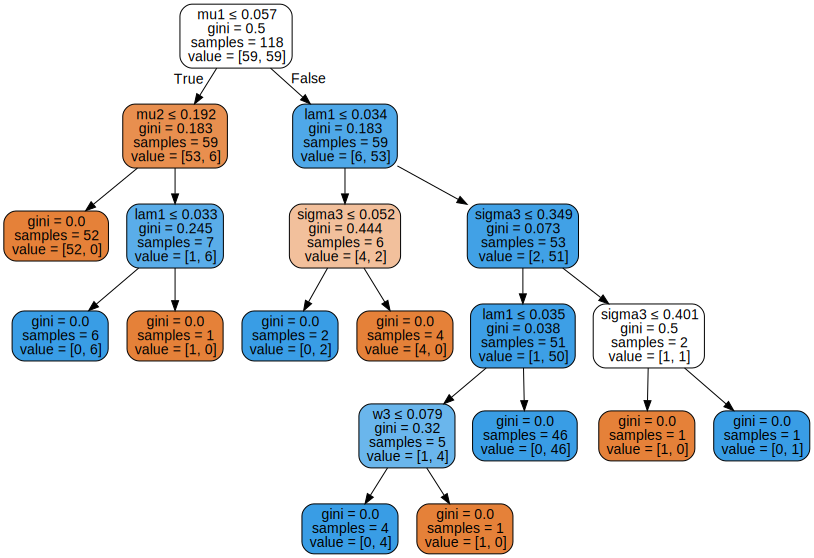

In [188]:
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_graphviz
from sklearn.model_selection import cross_val_score
import graphviz

clf = DecisionTreeClassifier(random_state=0)
print(np.mean(cross_val_score(clf, clf_dataframe, y.values, cv=5)))

clf =  DecisionTreeClassifier(random_state=0).fit(clf_dataframe,y.values)

dot_data = export_graphviz(clf, out_file=None, 
                      feature_names=clf_dataframe.columns,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 